## Lectura de Comtrades v1999 - BINARY

Los analogos V L1-N;V L2-N;V L3-N;I L1;I L2;I L3
Record has 4151 samples
Sampling rate is 5000 samples/sec.


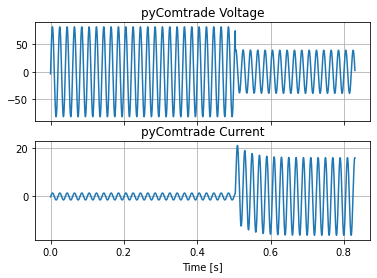

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 18 18:31:15 2020

@author: anavr
"""

import numpy as np
from scipy import signal, fftpack
from matplotlib import pyplot as plt
import pyComtrade
comtradeObj = pyComtrade.ComtradeRecord()
comtradeObj.read('./Comtrade TEST 1-1/L1L2L3_75%/BINAIRE/Test_1-1_ABC60_75%_BIN.cfg', './Comtrade TEST 1-1/L1L2L3_75%/BINAIRE/Test_1-1_ABC60_75%_BIN.dat')

print('Los analogos',comtradeObj.get_analog_ids())  # print the ids of the analog channels.

N = comtradeObj['endsamp'][-1]

print('Record has {} samples'.format(N))
print('Sampling rate is {} samples/sec.'.format(comtradeObj['samp'][-1]))

# Reading Phase A:
Voltage_A = comtradeObj['A'][0]['values']
Current_A = comtradeObj['A'][3]['values']

# Reading time vector:
time = comtradeObj.get_timestamps()

# Ploting with matplotlib
# pylab.plot(time,channelData)
f, axarr = plt.subplots(2, sharex=True)

axarr[0].plot(time, Voltage_A)
axarr[0].set_title('pyComtrade Voltage')
axarr[0].grid()
axarr[1].plot(time, Current_A)
axarr[1].set_title('pyComtrade Current')
axarr[1].set_ylim()  # bottom unchanged
axarr[1].grid()
axarr[1].set_xlabel('Time [s]')
plt.show()

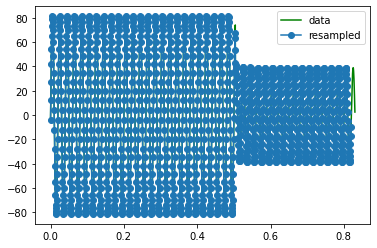

initial time 0.0
final time 0.8193786430722891


In [2]:
# Vector to resample: time, Voltage_A
fk=50
fs=5000
fs_user_cycle = 32
N1= fs_user_cycle
fs_user = fs_user_cycle * fk
fs_cycle = fs/fk
N=np.int(fs_cycle)
N_tot = np.int(len(Voltage_A)/fs_cycle)
new_Voltage_A = [0]
new_time = [0]
#print(N)
for i in np.arange(N_tot):
    xi=Voltage_A[i*N:i*N+N]
    ti=time[i*N:i*N+N]
    new_Voltage_A[i*N1:i*N1+N1] = signal.resample(xi, N1)
    new_time[i*N1:i*N1+N1] = np.linspace(ti[0], ti[-1], N1, endpoint=False)
    
plt.plot(time, Voltage_A, 'g-', new_time, new_Voltage_A, 'o-')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

print('initial time', new_time[0])
print('final time', new_time[-1])

## Filtro Antialising (Butterworth 2do Orden)

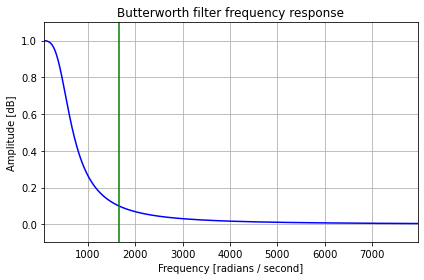

In [12]:
# Defining methods for the filter
def butter_lowpass(cutoff, fs, order):
    nyq = fs/2
    normal_cutoff = cutoff/nyq
    b,a = signal.butter(order, normal_cutoff, 'low', analog=True)
    return b,a

fk=50
# fs = np.ceil(1/cutoff * comtradeObj['samp'][-1])
fs = comtradeObj['samp'][-1]
cutoff = (fs-fk)/3
# fs = comtradeObj['samp'][-1]/50
order = 2
b,a = butter_lowpass(cutoff, fs, order)
# b,a = signal.butter(order, cutoff, 'low', analog=True)

w, h = signal.freqs(b, a)
# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# plt.subplot(2,1,1)
plt.title('Butterworth filter frequency response')
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
# plt.semilogx(0.5*fs*w/np.pi, 20 * np.log10(abs(h)))
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='green') # cutoff frequency
plt.tight_layout()

## Señal Filtrada con Antialising

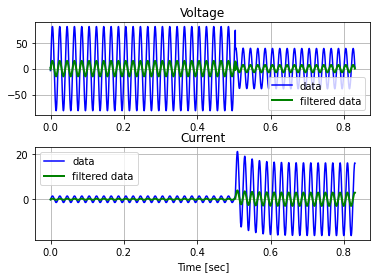

In [13]:
# zi = signal.lfilter_zi(b, a)
VA_Filtered = signal.lfilter(b,a,Voltage_A)
IA_Filtered = signal.lfilter(b,a,Current_A)

# print(VA_Filtered)
# print(len(Voltage_A))

plt.subplot(2, 1, 1)
plt.plot(time, Voltage_A, 'b-', label='data')
plt.plot(time, VA_Filtered, 'g-', linewidth=2, label='filtered data')
plt.title('Voltage')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, Current_A, 'b-', label='data')
plt.plot(time, IA_Filtered, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.title('Current')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

## Modulo de S&H y A/D (Quantizer)

quantizing_step 0.14512525408676202
quantizing signal size [-0.14512525 -0.          0.          0.14512525  0.14512525  0.29025051
  0.43537576  0.43537576  0.58050102  0.58050102]


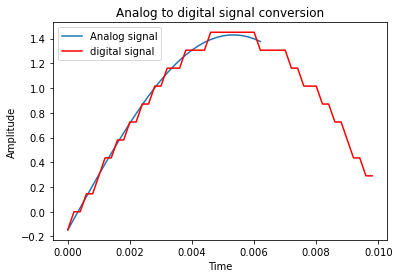

In [37]:
# Quantizer - S&H and ADC

quantizing_bits     = 8
quantizing_levels   = 2 ** quantizing_bits
quantizing_step     = (np.max(Current_A)-np.min(Current_A)) / quantizing_levels
#quantizing_step     = 2
print('quantizing_step', quantizing_step)

quantizing_signal   = np.round (Current_A / quantizing_step) * quantizing_step;
print('quantizing signal size', quantizing_signal[0:10])

fig = plt.figure ()
plt.plot (time[0:N1],  Current_A[0:N1],label='Analog signal'  );
#plt.stem (sampling_time, sampling_signal);
#plt.stem (time[0:50], quantizing_signal[0:50], linefmt='r-', markerfmt='rs', basefmt='r-');
plt.plot(time[0:N], quantizing_signal[0:N], 'r-',label='digital signal')
plt.title("Analog to digital signal conversion")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

plt.show()


## Transformada de Fourier (Filtro de componentes ortogonales basado en walsh 1er Orden)

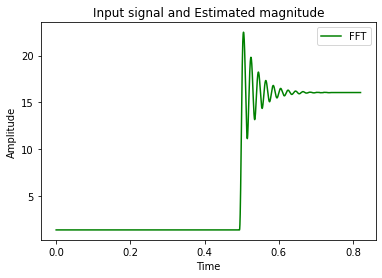

In [38]:
fs_cycle = fs/fk
N=np.int(fs_cycle/2)
N_tot = np.int(len(quantizing_signal)-N)
Xc = [0]*N_tot
Xs = [0]*N_tot
t = [0]*N_tot

ntaps = 1999
nyq = 0.5 * fs
cut = 1
#b, a = signal.iirfilter(2, 0.001, rs=None, btype='high', analog=False, ftype='butter')
highpass = signal.firwin(ntaps, cut, nyq=nyq, pass_zero=False, window='hamming', scale=False)
quantizing_signal = signal.lfilter(highpass, 1.0, quantizing_signal)

#print(N)
for i in np.arange(N_tot):
    xi=quantizing_signal[i:i+N]
    #xi = signal.medfilt(xi)
    #xi = signal.lfilter(b, a, xi)
    t[i]=time[i]
    Xc_sum = 0
    Xs_sum = 0
    for k in np.arange(N):
        Xc_temp=xi[k]*np.cos(2*np.pi*k/(N*2))
        Xc_sum=Xc_sum+Xc_temp
        Xs_temp=xi[k]*np.sin(2*np.pi*k/(N*2))
        Xs_sum=Xs_sum+Xs_temp        
    Xc[i]= 2/(N)*Xc_sum
    Xs[i]= 2/(N)* Xs_sum

X = np.sqrt(np.power(Xc,2)+np.power(Xs,2))
#Y = np.arctan(Xs/Xc)*180/np.pi
#X = signal.lfilter(b, a, X)
#plt.plot (time,  Current_A, label='Signal filtered');
plt.plot (t,  X, 'g-',label='FFT');
plt.title("Input signal and Estimated magnitude")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()

0.5


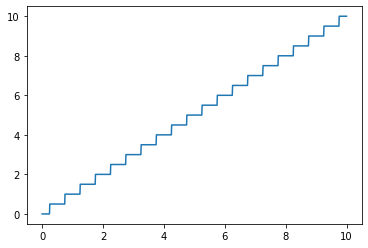

In [7]:
import numpy as np
import matplotlib.pyplot as plt

quantizing_bits     = 2
quantizing_levels   = 2 ** quantizing_bits / 2
q     = 1 / quantizing_levels
print(q)
#q = 0.5
x = np.linspace(0, 10, 1000)
y = q * np.round(x/q)
plt.plot(x,y)

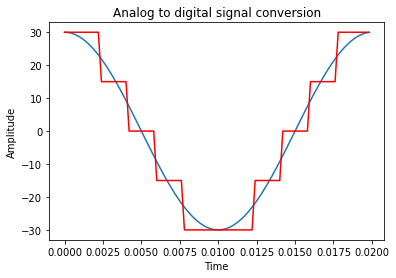

In [8]:
import numpy as np
import matplotlib.pyplot as plt

time_of_view        = 1.; # s.
analog_time         = np.linspace (0, time_of_view, 5000); # s.

sampling_rate       = 20.; # Hz
sampling_period     = 1. / sampling_rate; # s
sample_number       = np.int(np.round(time_of_view / sampling_period))
sampling_time       = np.linspace (0, time_of_view, sample_number);

carrier_frequency   = 50;
amplitude           = 30;
phase               = 0;

quantizing_bits     = 2;
quantizing_levels   = 2 ** quantizing_bits;
quantizing_step     = 60 / quantizing_levels;

def analog_signal (time_point):
    return amplitude * np.cos (2 * np.pi * carrier_frequency * time_point + phase);
sampling_signal     = analog_signal (analog_time);
#sampling_signal = VA_Filtered
quantizing_signal   = np.round (sampling_signal / quantizing_step) * quantizing_step;


fig = plt.figure ()
plt.plot (analog_time[0:100],   analog_signal(analog_time[0:100]) );
#plt.stem (sampling_time, sampling_signal);
#plt.stem (analog_time, quantizing_signal, linefmt='r-', markerfmt='rs', basefmt='r-');
plt.plot(analog_time[0:100], quantizing_signal[0:100], 'r-')
plt.title("Analog to digital signal conversion")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.show()


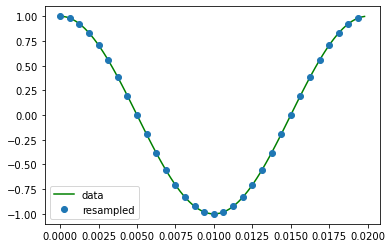

In [9]:
from scipy import signal
>>>
x = np.linspace(0, 1, 5000, endpoint=False)
freq=50
y = np.cos(2*np.pi*freq*x)
f = signal.resample(y, 1600)
xnew = np.linspace(0, 1, 1600, endpoint=False)
>>>
import matplotlib.pyplot as plt
plt.plot(x[0:100], y[0:100], 'g-', xnew[0:32], f[0:32], 'o')
plt.legend(['data', 'resampled'], loc='best')
plt.show()

In [10]:
Xs/Xc

TypeError: unsupported operand type(s) for /: 'list' and 'list'